In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from datetime import date
from dateutil.relativedelta import relativedelta

In [ ]:
# Functions
def bs_price(S, K, T, r, vol):
    """Calculates the price of a European call option using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    price =  (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return price

def bs_greeks(S, K, T, r, vol):
    """Calculates the Greeks of a European call option using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    # Greeks
    delta=norm.cdf(d1)
    gamma=norm.pdf(d1)/(S*vol*np.sqrt(T))
    df = np.exp(-r * T)
    theta=- (S * norm.pdf(d1) * vol) / (2 * np.sqrt(T)) - r * K *df* norm.cdf(d2)
    vega=S*norm.pdf(d1)*np.sqrt(T)
    rho=K*T*df*norm.cdf(d2)

    return {
        "Delta": delta,
        "Theta": theta,
        "Rho": rho,
        "Vega": vega,
         }

def aad_greeks(S, K, T, r, vol):
    """Calculates the derivatives of the Black-Scholes call option price with respect to its parameters using AAD method."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)


    s_bar = norm.cdf(d1)
    t_bar = r * norm.cdf(d2) * K * np.exp(-r * T)
    r_bar = T * norm.cdf(d2) * K * np.exp(-r * T)
    d1_bar = S * norm.pdf(d1)
    d2_bar = -norm.pdf(d2) * K * np.exp(-r * T)
    vol_bar = -np.sqrt(T) * d2_bar
    d1_bar += d2_bar
    t_bar += -0.5 * vol * d2_bar / np.sqrt(T)
    s_bar += d1_bar / (S * vol * np.sqrt(T))
    r_bar += d1_bar * T / (vol * np.sqrt(T))
    vol_bar += d1_bar * (-(np.log(S / K) + r * T) / (vol ** 2 * np.sqrt(T)) + 0.5 * np.sqrt(T))
    t_bar += d1_bar * (-0.5 * np.log(S / K) / (vol * T ** 1.5) + (r + 0.5 * vol ** 2) / (2 * vol * np.sqrt(T)))

    return {
        "Delta": s_bar,
        "Theta": -t_bar,
        "Rho": r_bar,
        "Vega": vol_bar,
         }



In [ ]:
S0 = 100.0
K = 105.0
r = 0.06
T = 1
sigma = 0.3
recovery_rate = 0.4 #Adjustable

In [ ]:
bs_price(S0, K, T, r, sigma)

12.422657818525288

In [ ]:
bs_greeks(S0, K, T, r, sigma)

{'Delta': 0.5743132075345124,
 'Theta': -8.580530798935547,
 'Rho': 45.00866293492596,
 'Vega': 39.20007348559993}

In [ ]:
aad_greeks(S0, K, T, r, sigma)

{'Delta': 0.5743132075345124,
 'Theta': -8.580530798935547,
 'Rho': 45.00866293492596,
 'Vega': 39.20007348559993}

In [ ]:
def generate_paths(S, T, r, vol, paths): 
    dt = T / paths
    return S * np.exp(np.cumsum((r - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * np.random.normal(size=(paths, int(T/dt))), axis=1))

In [ ]:
def mc_price(S, K, T, r, vol, paths):
    """Prices a European call option using Monte Carlo simulation."""

    prices = generate_paths(S, T, r, vol, paths)
    payoffs = np.maximum(prices[:, -1] - K, 0)
    option_price = np.mean(payoffs * np.exp(-r * T))

    return option_price, payoffs


In [ ]:
def compute_risk_metrics(S, K, T, r, vol, recovery_rate, paths):
    _, payoffs = mc_price(S, K, T, r, vol, paths)

    t = T
    Expected_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])
    Potential_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])

    for i in range (12):
        t = T - (T*i)/12 #calculate every after 1/12 portion of maturity time
        _, payoffs = mc_price(S, K, t, r, vol, paths)

        #By definition, EE and PE does not depend on default rate
        expected_exposure = np.mean(payoffs) * recovery_rate # Option price never negative
        potential_exposure = np.quantile(payoffs, 0.95) * recovery_rate #95% quantile

        Expected_Exposure.loc[i] = [T*i/12, expected_exposure]
        Potential_Exposure.loc[i] = [T*i/12, potential_exposure]

    return Expected_Exposure, Potential_Exposure



In [ ]:
bs_price(S0, K, T, r, sigma)

12.422657818525288

In [ ]:
mc_price(S0, K, T, r, sigma,500)[0]

11.715866940534767

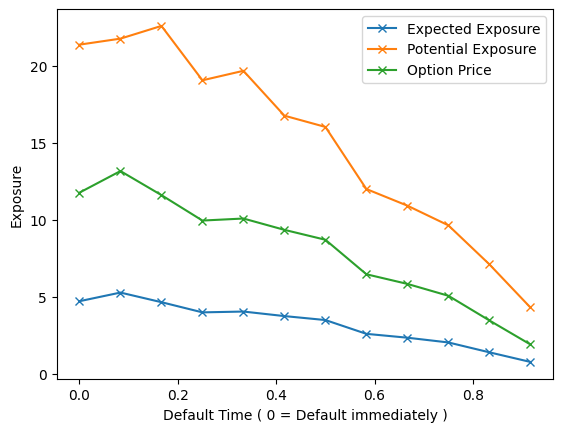

------------------------------------------------------
Expected Exposure
    default_time  Exposure
0       0.000000  4.702149
1       0.083333  5.263476
2       0.166667  4.638207
3       0.250000  3.976886
4       0.333333  4.029914
5       0.416667  3.735479
6       0.500000  3.477811
7       0.583333  2.581100
8       0.666667  2.330543
9       0.750000  2.022085
10      0.833333  1.381156
11      0.916667  0.757021
Potential Exposure
    default_time   Exposure
0       0.000000  21.372446
1       0.083333  21.762916
2       0.166667  22.589171
3       0.250000  19.055822
4       0.333333  19.672282
5       0.416667  16.757216
6       0.500000  16.025786
7       0.583333  11.989883
8       0.666667  10.910162
9       0.750000   9.631143
10      0.833333   7.098832
11      0.916667   4.296827
Option Price
    default_time      price
0       0.000000  11.755374
1       0.083333  13.158691
2       0.166667  11.595518
3       0.250000   9.942215
4       0.333333  10.074786
5       0.41

In [ ]:
Expected_Exposure, Potential_Exposure = compute_risk_metrics(S0, K, T, r, sigma, recovery_rate, 500)

# Plotting Expected_Exposure and Potential_Exposure
Option_Price = pd.DataFrame()
Option_Price['default_time'] = Expected_Exposure['default_time']
Option_Price['price'] = Expected_Exposure['Exposure'] / recovery_rate
plt.plot(Expected_Exposure['default_time'], Expected_Exposure['Exposure'], label='Expected Exposure', marker='x')
plt.plot(Potential_Exposure['default_time'], Potential_Exposure['Exposure'], label='Potential Exposure', marker='x')
plt.plot(Option_Price['default_time'], Option_Price['price'], label='Option Price', marker='x')

plt.xlabel('Default Time ( 0 = Default immediately )')
plt.ylabel('Exposure')
plt.legend()

plt.show()
print('------------------------------------------------------')
print('Expected Exposure')
print(Expected_Exposure)
print('Potential Exposure')
print(Potential_Exposure)
print('Option Price')
print(Option_Price)

In [ ]:
aad_greeks(S0, K, T, r, sigma)

{'Delta': 0.5743132075345124,
 'Theta': -8.580530798935547,
 'Rho': 45.00866293492596,
 'Vega': 39.20007348559993}